<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-2" data-toc-modified-id="Case-2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models-and-training" data-toc-modified-id="Models-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

***

# Case 2
Ville Kajander, Topias Paljakka and Ville Tuomi - Team 8<br>
Last edited: 28.02.2020<br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

***

# Background
The aim of this notebook is to study x-ray images of lungs using convolutional neural network.

***

# Data
The data contained images of healthy lungs and lungs with pneumonia. The data was downloaded from [here](https://data.mendeley.com/datasets/rscbjbr9sj/2). The size of the data was 1.16 GB and it was divided into training set and testing set. The training set had 1349 images of healthy lungs and 3883 images of lungs with pneumonia. The testing set had 234 images of healthy lungs and 390 images of lungs with pneumonia.

In [1]:
%pylab inline
import os, shutil

Populating the interactive namespace from numpy and matplotlib


### Hyper parameters:

In [2]:
proportions = (0.6, 0.2, 0.2) # Proportions between train, validation and test set
batch_size = 16
epochs = 3
target_size = (150,150)
model_dir = './models'
workers = 100 # Maximum number of processes to spin up when using process-based threading
is_saved = True

### Reorganizing the data:

Remove existing directories and make new directories.

In [3]:
train_dir = './train'
valid_dir = './validation'
test_dir = './test'
all_dirs = [train_dir, valid_dir, test_dir]

for d in all_dirs:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.mkdir(d)
    os.mkdir(os.path.join(d,'NORMAL'))
    os.mkdir(os.path.join(d,'PNEUMONIA'))
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']


List all normal and pneumonia image paths in original train and test data.

In [4]:
orig_dir = 'chest_xray/train'
orig_dir2 = 'chest_xray/test'

normal_images = [os.path.join(orig_dir, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir, 'NORMAL')) if x.endswith('.jpeg')]
normal_images += [os.path.join(orig_dir2, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir2, 'NORMAL')) if x.endswith('.jpeg')]
pneumonia_images = [os.path.join(orig_dir, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir, 'PNEUMONIA')) if x.endswith('.jpeg')]
pneumonia_images += [os.path.join(orig_dir2, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir2, 'PNEUMONIA')) if x.endswith('.jpeg')]


print('Num of normal images:', len(normal_images))
print('Num of pneumonia images:', len(pneumonia_images))

Num of normal images: 1583
Num of pneumonia images: 4273


Randomize the order of the images.

In [5]:
random.seed(1)
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

Copy the images from original directories to new ones and split them into train, validation and test folders.

In [6]:
# Splits given list into multiple lists with given proportions
def data_split(proportions, data):
    for x in np.split(data, np.cumsum(np.rint(np.dot(proportions, len(data))).astype(int))):
         yield x.tolist()

for directory, normals, pneumonias in zip(all_dirs, data_split(proportions, normal_images), 
                                                    data_split(proportions, pneumonia_images)):
    for file in normals + pneumonias:
        shutil.copyfile(file, os.path.join(directory, file.split('\\', 1)[1]))

### Create three image data generators, one for each data set.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg = ImageDataGenerator(rescale=1./255)

class_mode = 'binary'

train_generator = dg.flow_from_directory(
    train_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True)

dev_generator = dg.flow_from_directory(
    valid_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

test_generator = dg.flow_from_directory(
    test_dir, 
    target_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False)

Found 3514 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


Sampling a single image from one of the generators to test it.

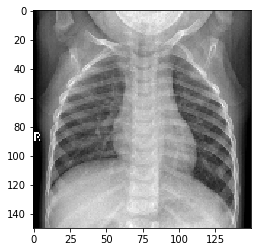

(150, 150, 3)

In [8]:
data_batch = train_generator[0][0]
imshow(data_batch[0])
show()
data_batch[0].shape

***

# Models and training

### Build and train process of our best model:

Layer selection

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential(name = 'Beast')
model.add(Conv2D(32, (3,3), padding='same', input_shape=data_batch[0].shape))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Compiling

In [10]:
from tensorflow.keras.metrics import SensitivityAtSpecificity

model.compile(loss='binary_crossentropy', metrics=[SensitivityAtSpecificity(0.9)])

Calculating the maximum steps per epoch and validation steps given sample size and batch size.

In [11]:
steps_per_epoch = int(train_generator.samples / batch_size)
validation_steps = int(dev_generator.samples / batch_size)

print('Maximum number of steps per epoch:', steps_per_epoch)
print('Maximum number of validation steps:', validation_steps)

Maximum number of steps per epoch: 219
Maximum number of validation steps: 73


Custom callback for simplified verbose output while training.

In [12]:
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class OneCallback(Callback):
    def __init__(self, epochs, steps_per_epoch, validation_steps):
        self.epochs = epochs
        self.steps_per_epoch = steps_per_epoch
        self.validation_steps = validation_steps        
        print('Starting...')
    
    def print_out(self):
        text = f'Epoch {self.epoch}/{self.epochs}'
        text += f'\nTraining steps: {self.train}/{self.steps_per_epoch}'
        text += f'\nValidation steps: {self.test}/{self.validation_steps}'        
        clear_output(wait=True)
        print(text)
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch + 1
        self.train = 0
        self.test = 0
        self.print_out()
    
    def on_train_batch_begin(self, batch, logs=None):
        self.train = batch + 1
        self.print_out()
        
    def on_test_batch_begin(self, batch, logs=None):
        self.test = batch + 1
        self.print_out()

Training

In [13]:
%%time
history = model.fit(train_generator,
                      workers=workers,
                      steps_per_epoch=steps_per_epoch,
                      verbose=0,
                      epochs=epochs,
                      validation_data=dev_generator,
                      validation_steps=validation_steps,
                      callbacks=[OneCallback(epochs, steps_per_epoch, validation_steps)])

Epoch 3/3
Training steps: 219/219
Validation steps: 73/73
Wall time: 10min 20s


Training history / metrics

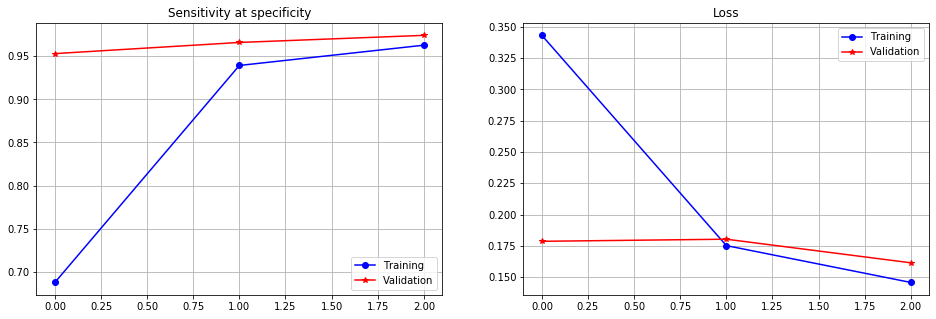

In [14]:
fig, axes = subplots(1,2,figsize=(16,5))

epochs_range = range(len(history.history['loss']))

#print(history.history.keys())

axes[0].plot(epochs_range, history.history['sensitivity_at_specificity'], 'bo-', label='Training')
axes[0].plot(epochs_range, history.history['val_sensitivity_at_specificity'], 'r*-', label='Validation')
axes[0].set_title('Sensitivity at specificity')
axes[0].grid()
axes[0].legend()

axes[1].plot(epochs_range, history.history['loss'], 'bo-', label='Training')
axes[1].plot(epochs_range, history.history['val_loss'], 'r*-', label='Validation')
axes[1].set_title('Loss')
axes[1].grid()
axes[1].legend()

show()

Saving the model for later.

In [15]:
if is_saved:
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)

    count = len(os.listdir(model_dir)) + 1

    new_file_path = f'{model_dir}/model_{count:03d}_epochs_{epochs}.h5'
    print(new_file_path)

    model.save(new_file_path)

./models/model_018_epochs_3.h5


### Load models:

A few of our previously build and trained models are loaded from memory.

In [16]:
models = [model]
models.append(load_model(f'{model_dir}/Trio_50.h5'))
models.append(load_model(f'{model_dir}/Zigzag_50.h5'))

all_colors = ['red', 'green', 'blue']

### Summary of each model:

In [17]:
for model in models:
    model.summary()
    print()

Model: "Beast"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0     

***

# Results and Discussion

### Testing and comparing results:

True values from test data.

In [18]:
labels = test_generator.classes

Values predicted from the test data by each model and the time it took.

In [19]:
import time
from IPython.display import Markdown

preds = []

for i, m in enumerate(models):
    start = time.time()
    preds.append(m.predict(test_generator, workers=workers))
    end = time.time()
    display(Markdown(f'**<font color={all_colors[i]}>{m.name}</font>** took {end - start:.0f} seconds'))
    
pnc = [x for x in zip(preds, [m.name for m in models], all_colors)]

**<font color=red>Beast</font>** took 33 seconds

**<font color=green>Trio</font>** took 16 seconds

**<font color=blue>Zigzag</font>** took 66 seconds

>Time it takes to do predictions is mostly determined by the amount of parameters the model has.

Plot true and predicted values.

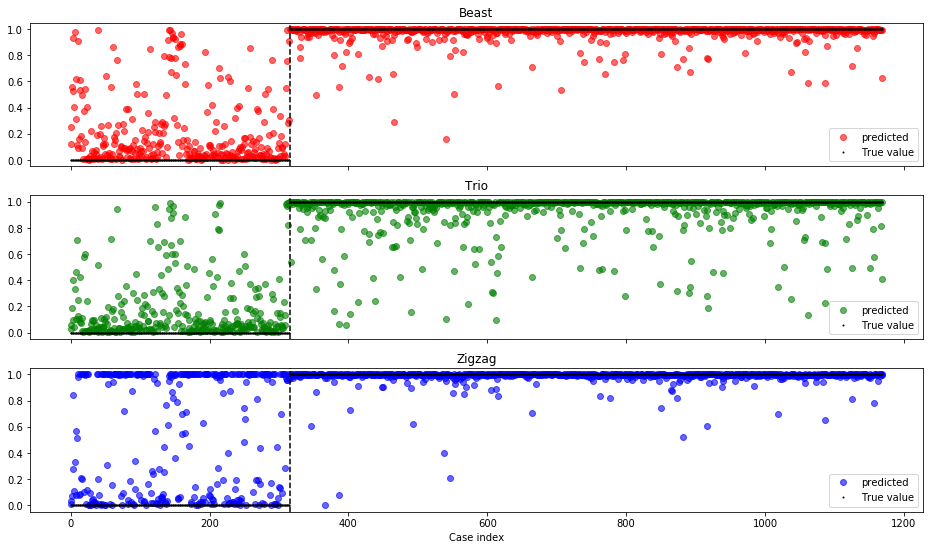

In [20]:
i = next(x[0] for x in enumerate(labels) if x[1]) #index where label turns to 1

fig, axes = subplots(len(preds), sharex=True, figsize=(16, 3 * len(preds)))

for n, (pred, name, color) in enumerate(pnc):
    axes[n].plot(pred, 'o', c=color, lw=2, alpha=0.6, label='predicted')
    axes[n].plot(labels, 'o', c='black', ms=1, label='True value')
    axes[n].axvline(i, c='black', ls='--', lw=1.5)
    axes[n].set_title(name)
    axes[n].legend(loc='lower right')
    
xlabel('Case index')
show()

>*insert analysis here*

### Confusion matrices

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

mask = '<br>' # newline
mask += '**<font color=%s>%s</font> =**' # colored name
mask += '$' # latex begin
mask += '\\begin{bmatrix}' # matrix begin
mask += '%d & %d\\\\ %d & %d'
mask += '\\end{bmatrix}' # matrix end
mask += '$' # latex end
mask += '<br>' # newline

s = ''
for pred, name, color in pnc:
    cm = confusion_matrix(labels, pred > 0.5).T
    s += mask % (color, name, *cm.flatten())
display(Markdown(s))   

<br>**<font color=red>Beast</font> =**$\begin{bmatrix}263 & 3\\ 53 & 851\end{bmatrix}$<br><br>**<font color=green>Trio</font> =**$\begin{bmatrix}278 & 42\\ 38 & 812\end{bmatrix}$<br><br>**<font color=blue>Zigzag</font> =**$\begin{bmatrix}142 & 4\\ 174 & 850\end{bmatrix}$<br>

><font color='red'>**Beast**</font> is achieving smallest false negatives and false positives overall.
>
><font color='green'>**Trio**</font> is suprisingly good second.
>
><font color='blue'>**Zigzag**</font> seems to have a preference towards the negative outcome.

### Classification reports

In [22]:
for pred, name, color in pnc:
    cr = classification_report(labels, pred > 0.5, target_names=['Normal (0)','Pneumonia (1)'])
    display(Markdown(f'**<font color={color}>{name}:</font>**'))
    print(cr)

**<font color=red>Beast:</font>**

               precision    recall  f1-score   support

   Normal (0)       0.99      0.83      0.90       316
Pneumonia (1)       0.94      1.00      0.97       854

     accuracy                           0.95      1170
    macro avg       0.97      0.91      0.94      1170
 weighted avg       0.95      0.95      0.95      1170



**<font color=green>Trio:</font>**

               precision    recall  f1-score   support

   Normal (0)       0.87      0.88      0.87       316
Pneumonia (1)       0.96      0.95      0.95       854

     accuracy                           0.93      1170
    macro avg       0.91      0.92      0.91      1170
 weighted avg       0.93      0.93      0.93      1170



**<font color=blue>Zigzag:</font>**

               precision    recall  f1-score   support

   Normal (0)       0.97      0.45      0.61       316
Pneumonia (1)       0.83      1.00      0.91       854

     accuracy                           0.85      1170
    macro avg       0.90      0.72      0.76      1170
 weighted avg       0.87      0.85      0.83      1170



>*insert analysis here*

### ROC curve (Receiver Operating Characteristic)

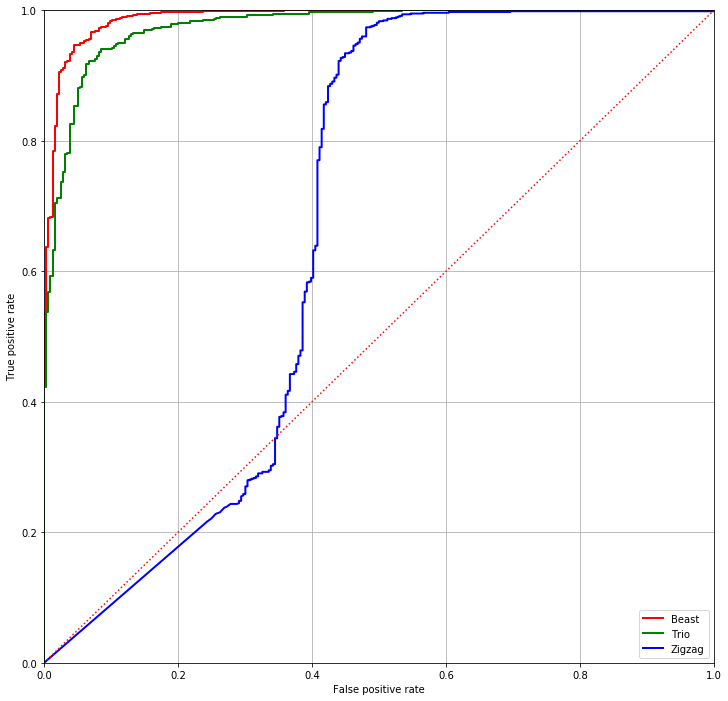

In [23]:
figure(figsize=(12,12))
for pred, name, color in pnc:
    fpr, tpr, tresholds = roc_curve(labels, pred, pos_label=1)
    plot(fpr, tpr, c=color, label=name, lw=2)    
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
xlim([0,1])
ylim([0,1])
legend()
grid()
show()

>*insert analysis here*

***

# Conclusions